In [92]:
import zipfile
import os
def extract_datasets(data_set_zip):
    zip_file_path = os.path.join(BASE_DIR, 'datasets-compressed', data_set_zip)

    extract_dir = os.path.join(BASE_DIR, 'datasets')
    os.makedirs(extract_dir, exist_ok=True)
    with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
        zip_ref.extractall(extract_dir)
    _extraction_cleanup(extract_dir)

def _extraction_cleanup(extract_dir):
    mac_side_effects = os.path.join(extract_dir, "__MACOSX")
    if os.path.exists(mac_side_effects):
        try: 
            os.remove(mac_side_effects)
        except PermissionError: 
            print("INFO: Was not able to clean macOS's side effects (__MACOSX) due to priviliage issue.\n"
                    " You can remove it manually")
            
BASE_DIR = os.getcwd()
extract_datasets('road-dataset.zip')

INFO: Was not able to clean macOS's side effects (__MACOSX) due to priviliage issue.
 You can remove it manually


In [68]:
import numpy as np 
import os
os.environ["SM_FRAMEWORK"] = "tf.keras"
import segmentation_models as sm
import keras
import cv2
import matplotlib.pyplot as plt
from focal_loss import BinaryFocalLoss

In [69]:
BACKBONE = 'resnet34'
RESIZE = (256, 256)
preprocess_input = sm.get_preprocessing(BACKBONE)

In [70]:
from pathlib import Path

def get_images_absolute_paths(base_dir):
    return sorted([str(file.absolute())
                   for file in Path(base_dir).iterdir()
                   if file.is_file()])


In [71]:
def load_images(image_paths):
    images = []
    for path in image_paths:
        if ".DS_Store" not in path: 
            img = cv2.imread(path)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            img = cv2.resize(img, RESIZE)
            images.append(img)
    return np.array(images)


In [74]:
def load_masks(mask_paths):
    masks = []
    for path in mask_paths:
        mask = cv2.imread(path)
        mask = cv2.cvtColor(mask, cv2.COLOR_BGR2GRAY)
        mask = cv2.resize(mask, (256, 256))
        mask = np.expand_dims(mask, axis=-1)
        mask = np.where(mask>0, 1, 0)
        masks.append(mask)
    return np.array(masks)

In [75]:
def plot_image_mask_result(x, y, z=None):
    fig, axs = plt.subplots(1, 3, figsize=(10, 5))
    axs[0].imshow(x)
    axs[1].imshow(y, cmap='gray')
    axs[2].imshow( np.zeros(x.shape) if z is None else z, cmap='gray')
    plt.show()

In [76]:
try:
    CLASS = 'road'
    BASE_DIR = os.path.join(os.getcwd(), 'datasets', CLASS)
    x_train_path = get_images_absolute_paths(os.path.join(BASE_DIR, 'train'))
    y_train_path = get_images_absolute_paths(os.path.join(BASE_DIR, 'trainannot'))
    x_val_path = get_images_absolute_paths(os.path.join(BASE_DIR, 'val'))
    y_val_path = get_images_absolute_paths(os.path.join(BASE_DIR, 'valannot'))
    x_test_path = get_images_absolute_paths(os.path.join(BASE_DIR, 'test'))
    y_test_path = get_images_absolute_paths(os.path.join(BASE_DIR, 'testannot'))
except FileNotFoundError:
    raise FileNotFoundError (f"class {CLASS} did not have a directory, go to first code snippet and\n"
          f"run it again with {CLASS}-dataset.zip or reproduce the data-set with the\n"
          "original_training_notebook.ipynb notebook")

In [77]:
y_train = load_masks(y_train_path)
x_train = load_images(x_train_path)
y_val = load_masks(y_val_path)
x_val = load_images(x_val_path)
y_test = load_masks(y_test_path)
x_test = load_images(x_test_path)

In [78]:
model = sm.Unet(
    BACKBONE,
    encoder_weights='imagenet',
    classes=1,
    activation='sigmoid',
    input_shape=(256, 256, 3))

In [79]:
metrics = [sm.metrics.IOUScore(threshold=0.5), sm.metrics.FScore(threshold=0.5)]

In [80]:
model.compile('Adam', loss=BinaryFocalLoss(gamma=2), metrics=metrics)

In [81]:
model.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 data (InputLayer)           [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 bn_data (BatchNormalizatio  (None, 256, 256, 3)          9         ['data[0][0]']                
 n)                                                                                               
                                                                                                  
 zero_padding2d_34 (ZeroPad  (None, 262, 262, 3)          0         ['bn_data[0][0]']             
 ding2D)                                                                                          
                                                                                            

In [96]:
import keras.callbacks
history = "Model was never ran"
history = model.fit(
    x_train,
    y_train,
    batch_size=16,
    epochs=50,
    verbose=1,
    validation_data=(x_val, y_val),
    callbacks=[keras.callbacks.EarlyStopping(patience=3, restore_best_weights=True)])

Epoch 1/50


KeyboardInterrupt: 

In [103]:
from tensorflow.keras.models import load_model
from tensorflow.keras.models import load_model
import segmentation_models as sm

custom_objects = {
    "IOUScore": sm.metrics.IOUScore,
    "FScore": sm.metrics.FScore
}

#IMPORTANT: for some reason the loaded model is not loaded properly 
# and does not perform as good as it did on creation. This bug
# needs to be resolved.
answer = input("This might override your model! Are you sure? y/n")
if(answer == 'y'):
    model = load_model(
        'mappify/cv_labratory/segmentation_lab/products/road_segmentor/model.tf',
          custom_objects=custom_objects)

In [104]:
evaluation = model.evaluate(x_test, y_test)
print("Loss:", evaluation[0])
print("Accuracy:", evaluation[1])

8/8 [==============================] - 12s 1s/step - loss: 2.4337 - iou_score: 7.3157e-05 - f1-score: 1.4629e-04
Loss: 2.4337034225463867
Accuracy: 7.315656694117934e-05


In [105]:
THRESHOLD = 0.5
prediction = model.predict(x_test)
prediction = np.where(prediction > THRESHOLD, 1, 0)

8/8 [==============================] - 12s 1s/step


INFO: Was not able to clean macOS's side effects (__MACOSX) due to priviliage issue.
 You can remove it manually
1/1 [==============================] - 0s 245ms/step


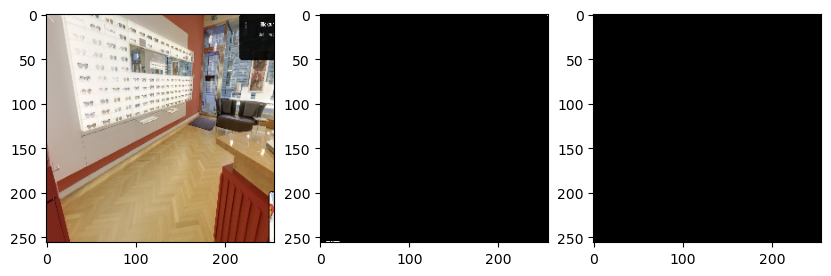

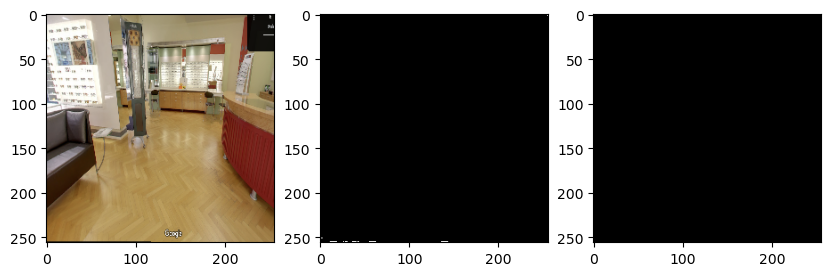

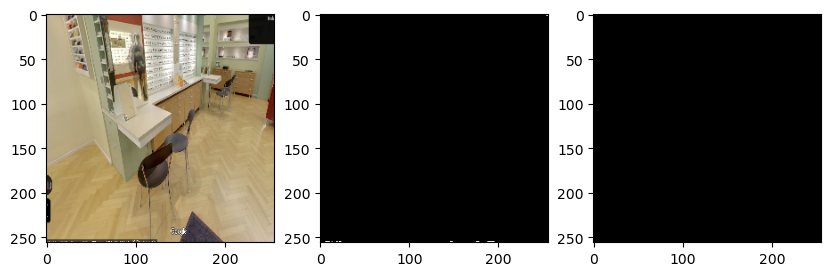

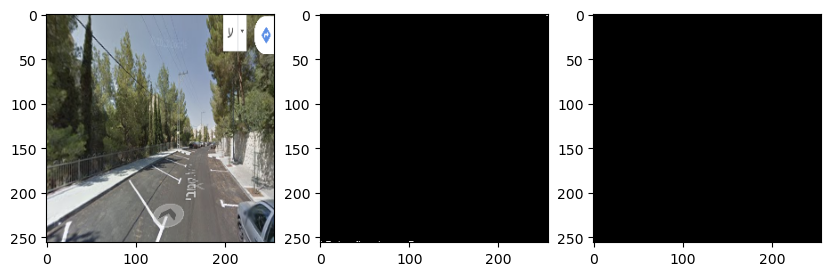

In [107]:
def check_real_data():
    sample_dir_path = os.path.join('datasets', 'google-maps-sample')
    samples_path = get_images_absolute_paths(sample_dir_path)
    sample_data = load_images(samples_path)
    THRESHOLD = 0.5
    prediction = model.predict(sample_data)
    prediction = np.where(prediction > THRESHOLD, 1, 0)
    for i in range(len(sample_data)):
        plot_image_mask_result(sample_data[i],prediction[i])
extract_datasets("google-maps-sample.zip")
check_real_data()

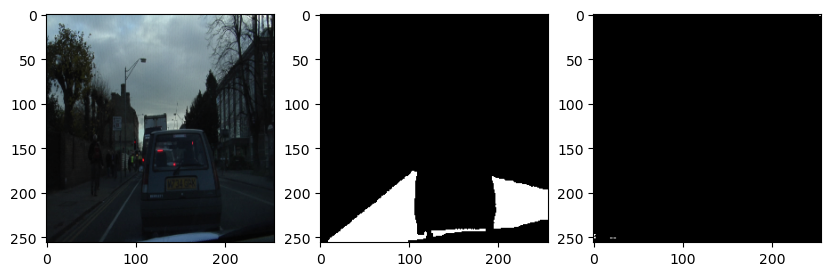

In [108]:
index = np.random.randint(0, x_test.shape[0])
plot_image_mask_result(x_test[index], y_test[index], prediction[index])

In [109]:
def save_model(model,model_params, name=None):
    import json
    from datetime import datetime
    current_time = datetime.now().strftime("%Y-%m-%d %H:%M:%S.%f")
    if name is None:
        name = "segmentor " + current_time

    segmentor_path = os.path.join(os.getcwd(), name)
    model_path = os.path.join(segmentor_path, "model.tf")
    report_path = os.path.join(segmentor_path, "report.json")

    os.makedirs(segmentor_path)

    with open(report_path, 'w') as file:
        json.dump(model_params, file, indent=4)
    model.save(model_path)
    print(f"INFO: Segmetor saved successfully to- \n{segmentor_path}")


params={
    'model': 'Unet',
    'backbone': BACKBONE,
    'image_resize': f"{RESIZE[0]}X{RESIZE[1]}",
    'history' : history,
    'Loss': evaluation[0],
    'Accuracy': evaluation[1]
}
save_model(model,params)

INFO:tensorflow:Assets written to: /Users/gilpasi/Desktop/study/year-3/final project/project/mappify/cv_labratory/segmentation_lab/segmentor 2024-04-12 23:03:32.906627/model.tf/assets


INFO:tensorflow:Assets written to: /Users/gilpasi/Desktop/study/year-3/final project/project/mappify/cv_labratory/segmentation_lab/segmentor 2024-04-12 23:03:32.906627/model.tf/assets


INFO: Segmetor saved successfully to- 
/Users/gilpasi/Desktop/study/year-3/final project/project/mappify/cv_labratory/segmentation_lab/segmentor 2024-04-12 23:03:32.906627
